Check cuda version

In [1]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In Linux, the environment variable `LD_LIBRARY_PATH` is a colon-separated set of directories where libraries should be searched for first, before the standard set of directories; this is useful when debugging a new library or using a nonstandard library for special purposes. - [source](https://askubuntu.com/questions/844578/what-does-manpath-ld-library-path-mean-in-linux)

__NOTE__: Run it before launching `jupyter`

In [2]:
!export LD_LIBRARY_PATH=/usr/local/cuda-10.0/lib64

In [5]:
PATH = '.'
PATH_DATA = PATH + r'/data/'
PATH_RUBERT = PATH + r'/ru_bert_tf'
PATH_RESULTS = PATH + r'/modelResults/'
train_file = r'train_2020_04+.csv'
valid_file = r'validate_2020_04+.csv'
test_file = r'test_2020_04+.csv'
train_file_tr = r'train_2020_04+_tr.csv'
valid_file_tr = r'validate_2020_04+_tr.csv'
test_file_tr = r'test_2020_04+_tr.csv'

In [4]:
!ls $PATH_RUBERT

bert_config.json		     bert_model.ckpt.index
bert_model.ckpt.data-00000-of-00001  vocab.txt


Clear the GPU if needed

In [5]:
!nvidia-smi

Wed Mar  3 04:26:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
from numba import cuda 

device = cuda.get_current_device()
device.reset()

In [6]:
!nvidia-smi

Tue Mar  2 06:54:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   51C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Test for GPU availability

In [6]:
import tensorflow as tf

tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

In [7]:
from deeppavlov.dataset_readers.basic_classification_reader import BasicClassificationDatasetReader
from deeppavlov.dataset_iterators.basic_classification_iterator import BasicClassificationDatasetIterator

from deeppavlov.core.data.simple_vocab import SimpleVocabulary

from deeppavlov.models.preprocessors.bert_preprocessor import BertPreprocessor
from deeppavlov.models.preprocessors.one_hotter import OneHotter
from deeppavlov.models.bert.bert_classifier import BertClassifierModel

from deeppavlov.metrics.roc_auc_score import roc_auc_score
from deeppavlov.metrics.fmeasure import round_f1_weighted
from deeppavlov.metrics.accuracy import sets_accuracy

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, hamming_loss, accuracy_score, \
    roc_auc_score, roc_curve, multilabel_confusion_matrix, confusion_matrix

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import time
import re
import ast

from tqdm import tqdm_notebook

import os

import warnings
warnings.filterwarnings('ignore')

# Data transformation

Removing (negative/positive) labels from target variable

In [8]:
df_train = pd.read_csv(PATH_DATA + train_file_tr)
df_train.sample(10)
# del df_train

,comment,topicsRaw,topics
13459,Все сказано оператору,['Uncategorized'],Uncategorized
59117,Всё устраивает,['Uncategorized'],Uncategorized
26347,Не сделали скидку по промокоду при покупке Нет...,['Taste'],Taste
54474,Удовольствие и удобство9,['Uncategorized'],Uncategorized
10672,Нет запаха,['Smoke & smell'],Smoke & smell
84851,Все ок,['Uncategorized'],Uncategorized
71826,Менеджер был вежлив все обьеснил выбрал удобно...,['Staff reliability'],Staff reliability
76207,"Команда работает отлично,во всем помогает.",['Staff reliability'],Staff reliability
55639,"Спасибо, девушка обслужила быстро без проблем,...","['Charger, holder or accessories reliability',...","Charger, holder or accessories reliability;Sta..."
70241,Пользуюсь 1ый день пока норм.,['Uncategorized'],Uncategorized


In [9]:
!head -20 $PATH_DATA$train_file

hash_message_id,0,id,clr_comment,en_comment,x
ca1252bac15399fb54dfad51e1ab8365a68ed288,['Uncategorized (positive)'],ca1252bac15399fb54dfad51e1ab8365a68ed288,"Удобно, практично10","Convenient, practical10",Uncategorized (positive)
45e64cd718fbb7fc7ae2e45d9685bc0b22999006,['Uncategorized (positive)'],45e64cd718fbb7fc7ae2e45d9685bc0b22999006,Лучше сигареты,Better cigarettes,Uncategorized (positive)
21ed433622b89d68d50fb8f16d14db2ce3492fe1,['Staff reliability (negative)'],21ed433622b89d68d50fb8f16d14db2ce3492fe1,Операторы долго не понимали что я хочу от них,Operators didn't understand for a long time what I wanted from them,Staff reliability (negative)
d514896e7260162cbaaebb08d381b1ce0a494652,['Uncategorized (positive)'],d514896e7260162cbaaebb08d381b1ce0a494652,В токих случаях я никому ничего не рекомендую,I don't recommend anything to anyone.,Uncategorized (positive)
b8dd9ae1c211b8d7223159aa4bf4ba71b4809c40,['Smoke & smell (positive)'],b8dd9ae1c211b8d7223159aa4bf4ba71b4809c40,"Удобство, н

In [10]:
!head -20 $PATH_DATA$train_file_tr

comment,topicsRaw,topics
"Удобно, практично10",['Uncategorized'],Uncategorized
Лучше сигареты,['Uncategorized'],Uncategorized
Операторы долго не понимали что я хочу от них,['Staff reliability'],Staff reliability
В токих случаях я никому ничего не рекомендую,['Uncategorized'],Uncategorized
"Удобство, нет запаха",['Smoke & smell'],Smoke & smell
"Грамотно все объяснили и посоветовали то,что мне нужно !",['Expertise'],Expertise
Обязательно порекомендую,['Uncategorized'],Uncategorized
Он лучше,['Uncategorized'],Uncategorized
Меня устрвиарет,['Uncategorized'],Uncategorized
"Удобно ,меньше вреда здоровью",['Alternative to cigarette'],Alternative to cigarette
Всё нравится !,['Uncategorized'],Uncategorized
"Очень хорошее обслуживание, отзывчивые сотрудники в магазине",['Staff reliability'],Staff reliability
Хороший сервис,['Staff reliability'],Staff reliability
По моим рекомендациям много друзей перешли на IQOS. Мне нравится),['Social inclusion'],Social inclusion
"Качественное обслуживание, веж

# Model description

* Model itself is BERT classifier - [`BertClassifierModel`](http://docs.deeppavlov.ai/en/master/apiref/models/bert.html#deeppavlov.models.bert.bert_classifier.BertClassifierModel) from DeepPavlov
* Optimizer is set to be [`AdamWeightDecayOptimizer`](https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/optimization.py#L87) from Google Research
* As a preprocessor for our inputs, we shall be using BERT trained on russian language - [__Conversational RuBERT__](http://docs.deeppavlov.ai/en/master/features/models/bert.html) from DeepPavlov
* As a vocabulary for target classes we shall use [`SimpleVocabulary`](http://docs.deeppavlov.ai/en/master/_modules/deeppavlov/core/data/simple_vocab.html) from DeepPavlov
* As a probability to labels processing method we shall use [`prob2labels`](http://docs.deeppavlov.ai/en/master/_modules/deeppavlov/models/classifiers/proba2labels.html) from DeepPavlov
* As a one hot encoder for target variable we shall use [`OneHotter`](https://docs.deeppavlov.ai/en/0.0.6.5/_modules/deeppavlov/models/preprocessors/one_hotter.html) from DeepPavlov
* As metrics we will use `sklearn.metrics`
* As additional metrics we can use following from DeepPavlov:
  * Accuracy measure - [`sets_accuracy`](http://docs.deeppavlov.ai/en/master/apiref/metrics.html#deeppavlov.metrics.accuracy.sets_accuracy)
  * F1 score - [`round_f1_weighted`](http://docs.deeppavlov.ai/en/master/apiref/metrics.html#deeppavlov.metrics.fmeasure.round_f1)
  * AUC score - [`roc_auc_score`](http://docs.deeppavlov.ai/en/master/apiref/metrics.html#deeppavlov.metrics.roc_auc_score.roc_auc_score)
  
# Create or load model
## Model definition
### Set `load = False` if you want to train model from scratch otherwise `load = True`

In [12]:
modelLoad = None
modelSave = r'model_020321'
PATH_LOAD = None
PATH_SAVE = None

if modelLoad is not None:
    PATH_LOAD = PATH_RESULTS + modelLoad
    classes = np.load(PATH_LOAD + r'/classes.npy', allow_pickle=True)
if modelSave is not None:
    if not os.path.exists(PATH_RESULTS + modelSave):
        os.mkdir(PATH_RESULTS + modelSave)
    PATH_SAVE = PATH_RESULTS + modelSave                  

reader = BasicClassificationDatasetReader()
data = reader.read(
    data_path = PATH_DATA, train = train_file_tr, valid = valid_file_tr,
    test = test_file_tr, class_sep =';', x = 'comment', y = 'topics'
)
                      
iterator = BasicClassificationDatasetIterator(data, shuffle = True)

if modelLoad is not None: mlb = MultiLabelBinarizer(classes = classes)
else: mlb = MultiLabelBinarizer()                      
mlb.fit_transform(iterator.get_instances('train')[1])

if modelSave is not None:
    np.save(PATH_SAVE + r'/classes.npy', mlb.classes_)

bert_preprocessor = BertPreprocessor(
    vocab_file=PATH_RUBERT + r'/vocab.txt',
    do_lower_case=False,
    max_seq_length=64
)

if PATH_SAVE is None: PATH_SAVE = PATH_LOAD
if PATH_LOAD is None: PATH_LOAD = PATH_SAVE

bert_classifier = BertClassifierModel(
    n_classes = len(mlb.classes_),
    return_probas = True,
    one_hot_labels = True,
    bert_config_file = PATH_RUBERT + r'/bert_config.json',
    pretrained_bert = r'bert_model.ckpt',
    save_path = PATH_SAVE + r'/model',
    load_path = PATH_LOAD + r'/model',
    keep_prob = 0.5,
    learning_rate = 1e-05,
    min_learning_rate = 1e-07,
    learning_rate_drop_patience = 5,
    learning_rate_drop_div = 2.0,
    multilabel = True
)
if modelLoad is not None: bert_classifier.load()








The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
Use standard file APIs to check for files with this prefix.


2021-03-03 04:33:35.971 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]



INFO:tensorflow:Restoring parameters from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model


2021-03-03 04:33:37.330 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


INFO:tensorflow:Restoring parameters from /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model


In [20]:
!nvidia-smi

Tue Mar  2 07:08:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   56C    P0    37W /  70W |  14451MiB / 15079MiB |     57%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Helper functions

In [13]:
def calculate_metrics(y_true, predictions, num_classes, micro = False, ts = None):
    if ts is None:
        y_pred = (predictions>0.5).astype(int)
    else:
        y_pred = (predictions>ts).astype(int)
        
    check =  ((y_pred.sum(axis=0) > 0).sum() == y_pred.shape[1]) | ((y_pred.sum(axis=0) > 0).sum() == 0)
    acc_total = 0.0 if check else \
        accuracy_score(y_true[:, 
                              (y_pred.sum(axis=0) != y_true.shape[0]) &
                              (y_pred.sum(axis=0) > 0)], 
                       y_pred[:, 
                              (y_pred.sum(axis=0) != y_true.shape[0]) &
                              (y_pred.sum(axis=0) > 0)])
    hamm_loss = hamming_loss(y_true, y_pred)
    f1_score_total = f1_score(y_true[:, y_true.sum(axis=0) > 0], 
                              y_pred[:, y_true.sum(axis=0) > 0], 
                              average='weighted')
    roc_auc_total = roc_auc_score(y_true[:, y_true.sum(axis=0) > 0],
                                  predictions[:, y_true.sum(axis=0) > 0], 
                                  average='weighted')

    
    acc_classes = None
    f1_scores_classes = None
    roc_auc_classes = None

    if micro:
        acc_classes = []
        f1_scores_classes = []
        roc_auc_classes = []

        
        for i in range(num_classes):
            acc_class = accuracy_score(y_true[:, i], y_pred[:, i])
            acc_classes.append(acc_class)
            f1_score_class = np.NAN if y_true[:, i].sum() == 0 else\
                f1_score(y_true[:, i], y_pred[:, i], average='macro')
            f1_scores_classes.append(f1_score_class)
            roc_auc_class = np.NAN if y_true[:, i].sum() == 0 else\
                roc_auc_score(y_true[:, i], predictions[:, i], average='macro')
            roc_auc_classes.append(roc_auc_class)
    
    return acc_total, acc_classes, hamm_loss, f1_score_total, f1_scores_classes, roc_auc_total, roc_auc_classes

def optimal_threshold(y_true, predictions, num_classes, verbose = False):
    thresholds = np.linspace(0,1,10000)
    
    # False negative rate
    fnr = np.zeros((num_classes, 10000))
    
    # False discovery rate
    fdr = np.zeros((num_classes, 10000))
    
    if verbose:
        print('Calculating optimal threshold')
        for i, threshold in enumerate(tqdm_notebook(thresholds)):
            tp = ((y_true == 1) & (predictions > threshold)).sum(axis=0)
            fn = ((y_true == 1) & (predictions <= threshold)).sum(axis=0)
            fp = ((y_true == 0) & (predictions > threshold)).sum(axis=0)
            fnr[:, i] = fn/(tp + fn)
            fdr[:, i] = fp/(tp + fp)
    else:
        for i, threshold in enumerate(thresholds):
            tp = ((y_true == 1) & (predictions > threshold)).sum(axis=0)
            fn = ((y_true == 1) & (predictions <= threshold)).sum(axis=0)
            fp = ((y_true == 0) & (predictions > threshold)).sum(axis=0)
            fnr[:, i] = fn/(tp + fn)
            fdr[:, i] = fp/(tp + fp)

    return thresholds[np.abs(fnr-fdr).argsort(axis=1)[:, 0]]

def get_preds(data_type, verbose = False):
    y_preds = []
    
    data = iterator.get_instances(data_type)
    
    if verbose:
        print(f'Predicting {data_type} data')
        for i in tqdm_notebook(range(0, len(data[0]), 256)):
            x = data[0][i:i + 256]

            y_pred = bert_classifier(bert_preprocessor(x))
            y_preds.append(y_pred)
    else:
        for i in range(0, len(data[0]), 256):
            x = data[0][i:i + 256]

            y_pred = bert_classifier(bert_preprocessor(x))
            y_preds.append(y_pred)
        
    y_preds = np.concatenate(y_preds, axis=0)
    y_true = data[1]

    y_true = mlb.transform(y_true)
    
    return  y_true, y_preds

### Training
#### Batch size

>The presented results confirm that using small batch sizes achieves the best training stability and
generalization performance, for a given computational cost, across a wide range of experiments. In
all cases the best results have been obtained with batch sizes m = 32 or smaller, often as small as
m = 2 or m = 4. - [source](https://arxiv.org/pdf/1804.07612.pdf)



In [22]:
best_score = 0.1
patience = 10
impatience = 0

print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')+" Training started")

for ep in range(300):
    nbatches = 0
    for x, y in iterator.gen_batches(batch_size=32, 
                                     data_type="train", shuffle=True):
        x_feat = bert_preprocessor(x)
        y_onehot = mlb.transform(y)
        bert_classifier.train_on_batch(x_feat, y_onehot)
        nbatches += 1
        
        if nbatches % 200 == 0:
            y_true, y_preds = get_preds('valid')
            acc, _, hamm, f1, _, roc_auc, _ = \
                calculate_metrics(y_true, y_preds, len(mlb.classes_))
            print(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')+ \
                  f" Batches done: {nbatches}.Validaiton accuracy: {acc:.5f}, F1 score: {f1:.5f}, hamming loss {hamm:.5f}, ROC-AUC: {roc_auc:.5f}")
            if f1 > best_score:
                bert_classifier.save()
                print("New best F1 score. Saving model.")
                best_score = f1    
                impatience = 0            
            
    
    print(f"Epochs done: {ep+1}")
    impatience += 1
    if impatience == patience:
        print("Out of patience. Stop training.")
        break

2021-03-02 07:08:37 Training started
2021-03-02 07:11:02 Batches done: 200.Validaiton accuracy: 0.00000, F1 score: 0.00000, hamming loss 0.03023, ROC-AUC: 0.67779
2021-03-02 07:13:22 Batches done: 400.Validaiton accuracy: 0.00000, F1 score: 0.00000, hamming loss 0.03023, ROC-AUC: 0.66831
2021-03-02 07:15:42 Batches done: 600.Validaiton accuracy: 0.00000, F1 score: 0.00000, hamming loss 0.03023, ROC-AUC: 0.67570
2021-03-02 07:18:03 Batches done: 800.Validaiton accuracy: 0.00000, F1 score: 0.00000, hamming loss 0.03023, ROC-AUC: 0.69933


2021-03-02 07:20:23.678 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:20:23 Batches done: 1000.Validaiton accuracy: 0.83797, F1 score: 0.20068, hamming loss 0.02569, ROC-AUC: 0.78141

New best F1 score. Saving model.


2021-03-02 07:22:47.151 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:22:47 Batches done: 1200.Validaiton accuracy: 0.69029, F1 score: 0.29670, hamming loss 0.02295, ROC-AUC: 0.81692
New best F1 score. Saving model.


2021-03-02 07:25:09.989 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:25:09 Batches done: 1400.Validaiton accuracy: 0.59132, F1 score: 0.42522, hamming loss 0.02087, ROC-AUC: 0.86359
New best F1 score. Saving model.


2021-03-02 07:27:32.819 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:27:32 Batches done: 1600.Validaiton accuracy: 0.58609, F1 score: 0.48237, hamming loss 0.01992, ROC-AUC: 0.89246
New best F1 score. Saving model.


2021-03-02 07:29:55.664 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:29:55 Batches done: 1800.Validaiton accuracy: 0.62794, F1 score: 0.51593, hamming loss 0.01890, ROC-AUC: 0.91085
New best F1 score. Saving model.


2021-03-02 07:32:18.561 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:32:18 Batches done: 2000.Validaiton accuracy: 0.65029, F1 score: 0.55237, hamming loss 0.01761, ROC-AUC: 0.91982
New best F1 score. Saving model.


2021-03-02 07:34:41.620 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:34:41 Batches done: 2200.Validaiton accuracy: 0.69777, F1 score: 0.57713, hamming loss 0.01676, ROC-AUC: 0.92949
New best F1 score. Saving model.


2021-03-02 07:37:04.646 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:37:04 Batches done: 2400.Validaiton accuracy: 0.71726, F1 score: 0.60124, hamming loss 0.01572, ROC-AUC: 0.93810
New best F1 score. Saving model.


2021-03-02 07:39:27.729 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:39:27 Batches done: 2600.Validaiton accuracy: 0.73726, F1 score: 0.60169, hamming loss 0.01565, ROC-AUC: 0.94112
New best F1 score. Saving model.
Epochs done: 1


2021-03-02 07:43:00.452 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:43:00 Batches done: 200.Validaiton accuracy: 0.70793, F1 score: 0.60848, hamming loss 0.01544, ROC-AUC: 0.94616
New best F1 score. Saving model.


2021-03-02 07:45:23.610 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:45:23 Batches done: 400.Validaiton accuracy: 0.72752, F1 score: 0.61800, hamming loss 0.01487, ROC-AUC: 0.94967
New best F1 score. Saving model.


2021-03-02 07:47:46.706 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:47:46 Batches done: 600.Validaiton accuracy: 0.73428, F1 score: 0.61807, hamming loss 0.01475, ROC-AUC: 0.95096
New best F1 score. Saving model.


2021-03-02 07:50:10.31 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:50:10 Batches done: 800.Validaiton accuracy: 0.63788, F1 score: 0.63741, hamming loss 0.01453, ROC-AUC: 0.95316
New best F1 score. Saving model.


2021-03-02 07:52:33.115 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:52:33 Batches done: 1000.Validaiton accuracy: 0.66691, F1 score: 0.64986, hamming loss 0.01452, ROC-AUC: 0.95265
New best F1 score. Saving model.


2021-03-02 07:54:56.402 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:54:56 Batches done: 1200.Validaiton accuracy: 0.65039, F1 score: 0.65704, hamming loss 0.01398, ROC-AUC: 0.95747
New best F1 score. Saving model.


2021-03-02 07:57:19.563 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:57:19 Batches done: 1400.Validaiton accuracy: 0.68690, F1 score: 0.67857, hamming loss 0.01352, ROC-AUC: 0.95648
New best F1 score. Saving model.


2021-03-02 07:59:42.830 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 07:59:42 Batches done: 1600.Validaiton accuracy: 0.69706, F1 score: 0.69544, hamming loss 0.01322, ROC-AUC: 0.95853
New best F1 score. Saving model.


2021-03-02 08:02:06.90 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:02:06 Batches done: 1800.Validaiton accuracy: 0.67911, F1 score: 0.70817, hamming loss 0.01279, ROC-AUC: 0.95797
New best F1 score. Saving model.


2021-03-02 08:04:29.467 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:04:29 Batches done: 2000.Validaiton accuracy: 0.67091, F1 score: 0.70936, hamming loss 0.01287, ROC-AUC: 0.95969
New best F1 score. Saving model.


2021-03-02 08:06:52.753 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:06:52 Batches done: 2200.Validaiton accuracy: 0.68885, F1 score: 0.72183, hamming loss 0.01225, ROC-AUC: 0.96249
New best F1 score. Saving model.


2021-03-02 08:09:16.115 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:09:16 Batches done: 2400.Validaiton accuracy: 0.69788, F1 score: 0.72927, hamming loss 0.01213, ROC-AUC: 0.96297
New best F1 score. Saving model.


2021-03-02 08:11:39.394 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:11:39 Batches done: 2600.Validaiton accuracy: 0.69849, F1 score: 0.73577, hamming loss 0.01205, ROC-AUC: 0.96416
New best F1 score. Saving model.
Epochs done: 2


2021-03-02 08:15:12.486 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:15:12 Batches done: 200.Validaiton accuracy: 0.68998, F1 score: 0.74426, hamming loss 0.01191, ROC-AUC: 0.96554
New best F1 score. Saving model.
2021-03-02 08:17:35 Batches done: 400.Validaiton accuracy: 0.70188, F1 score: 0.72673, hamming loss 0.01214, ROC-AUC: 0.96405
2021-03-02 08:19:56 Batches done: 600.Validaiton accuracy: 0.68916, F1 score: 0.74090, hamming loss 0.01195, ROC-AUC: 0.96592


2021-03-02 08:22:17.254 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:22:17 Batches done: 800.Validaiton accuracy: 0.69213, F1 score: 0.74542, hamming loss 0.01181, ROC-AUC: 0.96533
New best F1 score. Saving model.


2021-03-02 08:24:40.914 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:24:40 Batches done: 1000.Validaiton accuracy: 0.68137, F1 score: 0.75585, hamming loss 0.01165, ROC-AUC: 0.96830
New best F1 score. Saving model.


2021-03-02 08:27:04.275 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:27:04 Batches done: 1200.Validaiton accuracy: 0.66742, F1 score: 0.75983, hamming loss 0.01150, ROC-AUC: 0.96885
New best F1 score. Saving model.
2021-03-02 08:29:27 Batches done: 1400.Validaiton accuracy: 0.68701, F1 score: 0.75859, hamming loss 0.01136, ROC-AUC: 0.96895
2021-03-02 08:31:48 Batches done: 1600.Validaiton accuracy: 0.67603, F1 score: 0.75149, hamming loss 0.01145, ROC-AUC: 0.96871
2021-03-02 08:34:09 Batches done: 1800.Validaiton accuracy: 0.69685, F1 score: 0.75767, hamming loss 0.01132, ROC-AUC: 0.96929


2021-03-02 08:36:29.711 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:36:29 Batches done: 2000.Validaiton accuracy: 0.68947, F1 score: 0.76565, hamming loss 0.01136, ROC-AUC: 0.97021
New best F1 score. Saving model.


2021-03-02 08:38:53.210 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:38:53 Batches done: 2200.Validaiton accuracy: 0.69060, F1 score: 0.77116, hamming loss 0.01102, ROC-AUC: 0.97039
New best F1 score. Saving model.


2021-03-02 08:41:16.768 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:41:16 Batches done: 2400.Validaiton accuracy: 0.68383, F1 score: 0.77801, hamming loss 0.01104, ROC-AUC: 0.97108
New best F1 score. Saving model.


2021-03-02 08:43:40.266 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:43:40 Batches done: 2600.Validaiton accuracy: 0.69347, F1 score: 0.78253, hamming loss 0.01089, ROC-AUC: 0.96961
New best F1 score. Saving model.
Epochs done: 3


2021-03-02 08:47:13.543 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:47:13 Batches done: 200.Validaiton accuracy: 0.69449, F1 score: 0.78862, hamming loss 0.01076, ROC-AUC: 0.97081
New best F1 score. Saving model.


2021-03-02 08:49:37.167 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 08:49:37 Batches done: 400.Validaiton accuracy: 0.69644, F1 score: 0.79425, hamming loss 0.01069, ROC-AUC: 0.97189
New best F1 score. Saving model.
2021-03-02 08:52:00 Batches done: 600.Validaiton accuracy: 0.69890, F1 score: 0.78394, hamming loss 0.01070, ROC-AUC: 0.97170
2021-03-02 08:54:21 Batches done: 800.Validaiton accuracy: 0.69419, F1 score: 0.78577, hamming loss 0.01067, ROC-AUC: 0.97231
2021-03-02 08:56:42 Batches done: 1000.Validaiton accuracy: 0.70188, F1 score: 0.79279, hamming loss 0.01059, ROC-AUC: 0.97199
2021-03-02 08:59:04 Batches done: 1200.Validaiton accuracy: 0.69706, F1 score: 0.79227, hamming loss 0.01055, ROC-AUC: 0.97328


2021-03-02 09:01:24.982 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 09:01:24 Batches done: 1400.Validaiton accuracy: 0.70577, F1 score: 0.79967, hamming loss 0.01049, ROC-AUC: 0.97283
New best F1 score. Saving model.
2021-03-02 09:03:48 Batches done: 1600.Validaiton accuracy: 0.70208, F1 score: 0.79544, hamming loss 0.01052, ROC-AUC: 0.97234
2021-03-02 09:06:09 Batches done: 1800.Validaiton accuracy: 0.70598, F1 score: 0.79663, hamming loss 0.01046, ROC-AUC: 0.97299
2021-03-02 09:08:30 Batches done: 2000.Validaiton accuracy: 0.69419, F1 score: 0.78928, hamming loss 0.01068, ROC-AUC: 0.97322
2021-03-02 09:10:51 Batches done: 2200.Validaiton accuracy: 0.70782, F1 score: 0.79876, hamming loss 0.01043, ROC-AUC: 0.97332


2021-03-02 09:13:12.371 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 09:13:12 Batches done: 2400.Validaiton accuracy: 0.70700, F1 score: 0.80391, hamming loss 0.01035, ROC-AUC: 0.97391
New best F1 score. Saving model.
2021-03-02 09:15:36 Batches done: 2600.Validaiton accuracy: 0.70188, F1 score: 0.79817, hamming loss 0.01044, ROC-AUC: 0.97415
Epochs done: 4
2021-03-02 09:19:06 Batches done: 200.Validaiton accuracy: 0.69798, F1 score: 0.78970, hamming loss 0.01070, ROC-AUC: 0.97282


2021-03-02 09:21:27.673 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 09:21:27 Batches done: 400.Validaiton accuracy: 0.70916, F1 score: 0.80796, hamming loss 0.01037, ROC-AUC: 0.97419
New best F1 score. Saving model.
2021-03-02 09:23:51 Batches done: 600.Validaiton accuracy: 0.70680, F1 score: 0.79918, hamming loss 0.01050, ROC-AUC: 0.97358
2021-03-02 09:26:12 Batches done: 800.Validaiton accuracy: 0.70977, F1 score: 0.80192, hamming loss 0.01040, ROC-AUC: 0.97409
2021-03-02 09:28:33 Batches done: 1000.Validaiton accuracy: 0.71100, F1 score: 0.80343, hamming loss 0.01039, ROC-AUC: 0.97368
2021-03-02 09:30:54 Batches done: 1200.Validaiton accuracy: 0.70772, F1 score: 0.80401, hamming loss 0.01045, ROC-AUC: 0.97387
2021-03-02 09:33:14 Batches done: 1400.Validaiton accuracy: 0.71008, F1 score: 0.80479, hamming loss 0.01038, ROC-AUC: 0.97436
2021-03-02 09:35:35 Batches done: 1600.Validaiton accuracy: 0.70680, F1 score: 0.80177, hamming loss 0.01049, ROC-AUC: 0.97389
2021-03-02 09:37:56 Batches done: 1800.Validaiton accuracy: 0.70495, F1 score: 0.

2021-03-02 09:40:17.411 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 09:40:17 Batches done: 2000.Validaiton accuracy: 0.71890, F1 score: 0.81177, hamming loss 0.01016, ROC-AUC: 0.97493
New best F1 score. Saving model.
2021-03-02 09:42:41 Batches done: 2200.Validaiton accuracy: 0.70854, F1 score: 0.79986, hamming loss 0.01049, ROC-AUC: 0.97503
2021-03-02 09:45:02 Batches done: 2400.Validaiton accuracy: 0.71213, F1 score: 0.80387, hamming loss 0.01045, ROC-AUC: 0.97477
2021-03-02 09:47:23 Batches done: 2600.Validaiton accuracy: 0.72013, F1 score: 0.81128, hamming loss 0.01016, ROC-AUC: 0.97500
Epochs done: 5
2021-03-02 09:50:54 Batches done: 200.Validaiton accuracy: 0.71644, F1 score: 0.80902, hamming loss 0.01017, ROC-AUC: 0.97547


2021-03-02 09:53:14.964 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 09:53:14 Batches done: 400.Validaiton accuracy: 0.71880, F1 score: 0.81231, hamming loss 0.01005, ROC-AUC: 0.97493
New best F1 score. Saving model.
2021-03-02 09:55:38 Batches done: 600.Validaiton accuracy: 0.70926, F1 score: 0.80909, hamming loss 0.01044, ROC-AUC: 0.97441
2021-03-02 09:57:59 Batches done: 800.Validaiton accuracy: 0.71511, F1 score: 0.81043, hamming loss 0.01018, ROC-AUC: 0.97502
2021-03-02 10:00:20 Batches done: 1000.Validaiton accuracy: 0.71716, F1 score: 0.80724, hamming loss 0.01031, ROC-AUC: 0.97446
2021-03-02 10:02:41 Batches done: 1200.Validaiton accuracy: 0.70813, F1 score: 0.81015, hamming loss 0.01048, ROC-AUC: 0.97523
2021-03-02 10:05:02 Batches done: 1400.Validaiton accuracy: 0.70608, F1 score: 0.80612, hamming loss 0.01045, ROC-AUC: 0.97529
2021-03-02 10:07:22 Batches done: 1600.Validaiton accuracy: 0.71788, F1 score: 0.80951, hamming loss 0.01012, ROC-AUC: 0.97575


2021-03-02 10:09:43.767 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 10:09:43 Batches done: 1800.Validaiton accuracy: 0.72126, F1 score: 0.81414, hamming loss 0.01007, ROC-AUC: 0.97558
New best F1 score. Saving model.
2021-03-02 10:12:07 Batches done: 2000.Validaiton accuracy: 0.70895, F1 score: 0.81232, hamming loss 0.01028, ROC-AUC: 0.97518
2021-03-02 10:14:28 Batches done: 2200.Validaiton accuracy: 0.71644, F1 score: 0.80793, hamming loss 0.01022, ROC-AUC: 0.97462
2021-03-02 10:16:48 Batches done: 2400.Validaiton accuracy: 0.71962, F1 score: 0.81014, hamming loss 0.01018, ROC-AUC: 0.97529
2021-03-02 10:19:09 Batches done: 2600.Validaiton accuracy: 0.70639, F1 score: 0.80535, hamming loss 0.01042, ROC-AUC: 0.97521
Epochs done: 6
2021-03-02 10:22:40 Batches done: 200.Validaiton accuracy: 0.70741, F1 score: 0.81048, hamming loss 0.01029, ROC-AUC: 0.97599
2021-03-02 10:25:00 Batches done: 400.Validaiton accuracy: 0.71880, F1 score: 0.81395, hamming loss 0.01008, ROC-AUC: 0.97561
2021-03-02 10:27:21 Batches done: 600.Validaiton accuracy: 0.7152

2021-03-02 10:48:28.360 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 10:48:28 Batches done: 2400.Validaiton accuracy: 0.71962, F1 score: 0.81500, hamming loss 0.01021, ROC-AUC: 0.97573
New best F1 score. Saving model.
2021-03-02 10:50:52 Batches done: 2600.Validaiton accuracy: 0.72567, F1 score: 0.81406, hamming loss 0.01000, ROC-AUC: 0.97525
Epochs done: 7
2021-03-02 10:54:22 Batches done: 200.Validaiton accuracy: 0.71562, F1 score: 0.81495, hamming loss 0.01019, ROC-AUC: 0.97615
2021-03-02 10:56:43 Batches done: 400.Validaiton accuracy: 0.71080, F1 score: 0.81298, hamming loss 0.01028, ROC-AUC: 0.97542
2021-03-02 10:59:04 Batches done: 600.Validaiton accuracy: 0.71603, F1 score: 0.81154, hamming loss 0.01019, ROC-AUC: 0.97554
2021-03-02 11:01:24 Batches done: 800.Validaiton accuracy: 0.71572, F1 score: 0.81472, hamming loss 0.01013, ROC-AUC: 0.97556


2021-03-02 11:03:45.685 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 11:03:45 Batches done: 1000.Validaiton accuracy: 0.72167, F1 score: 0.81520, hamming loss 0.01002, ROC-AUC: 0.97535
New best F1 score. Saving model.


2021-03-02 11:06:09.451 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 11:06:09 Batches done: 1200.Validaiton accuracy: 0.71490, F1 score: 0.81533, hamming loss 0.01021, ROC-AUC: 0.97535
New best F1 score. Saving model.


2021-03-02 11:08:33.312 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 11:08:33 Batches done: 1400.Validaiton accuracy: 0.71788, F1 score: 0.81659, hamming loss 0.01011, ROC-AUC: 0.97547
New best F1 score. Saving model.
2021-03-02 11:10:57 Batches done: 1600.Validaiton accuracy: 0.71470, F1 score: 0.81544, hamming loss 0.01010, ROC-AUC: 0.97556
2021-03-02 11:13:17 Batches done: 1800.Validaiton accuracy: 0.71121, F1 score: 0.81525, hamming loss 0.01023, ROC-AUC: 0.97567
2021-03-02 11:15:38 Batches done: 2000.Validaiton accuracy: 0.71623, F1 score: 0.81546, hamming loss 0.01013, ROC-AUC: 0.97565


2021-03-02 11:17:59.262 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 11:17:59 Batches done: 2200.Validaiton accuracy: 0.71306, F1 score: 0.81694, hamming loss 0.01012, ROC-AUC: 0.97649
New best F1 score. Saving model.
2021-03-02 11:20:23 Batches done: 2400.Validaiton accuracy: 0.71900, F1 score: 0.81240, hamming loss 0.01015, ROC-AUC: 0.97584
2021-03-02 11:22:43 Batches done: 2600.Validaiton accuracy: 0.71449, F1 score: 0.81561, hamming loss 0.01026, ROC-AUC: 0.97533
Epochs done: 8


2021-03-02 11:26:14.696 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 11:26:14 Batches done: 200.Validaiton accuracy: 0.71264, F1 score: 0.81719, hamming loss 0.01029, ROC-AUC: 0.97533
New best F1 score. Saving model.


2021-03-02 11:28:38.586 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 11:28:38 Batches done: 400.Validaiton accuracy: 0.71429, F1 score: 0.81745, hamming loss 0.01019, ROC-AUC: 0.97546
New best F1 score. Saving model.
2021-03-02 11:31:02 Batches done: 600.Validaiton accuracy: 0.71080, F1 score: 0.81013, hamming loss 0.01029, ROC-AUC: 0.97451
2021-03-02 11:33:23 Batches done: 800.Validaiton accuracy: 0.70865, F1 score: 0.81158, hamming loss 0.01035, ROC-AUC: 0.97493
2021-03-02 11:35:44 Batches done: 1000.Validaiton accuracy: 0.71654, F1 score: 0.81228, hamming loss 0.01018, ROC-AUC: 0.97458
2021-03-02 11:38:04 Batches done: 1200.Validaiton accuracy: 0.71039, F1 score: 0.81137, hamming loss 0.01036, ROC-AUC: 0.97432
2021-03-02 11:40:25 Batches done: 1400.Validaiton accuracy: 0.71500, F1 score: 0.81490, hamming loss 0.01019, ROC-AUC: 0.97475
2021-03-02 11:42:46 Batches done: 1600.Validaiton accuracy: 0.70957, F1 score: 0.81310, hamming loss 0.01038, ROC-AUC: 0.97446
2021-03-02 11:45:06 Batches done: 1800.Validaiton accuracy: 0.70947, F1 score: 0.

2021-03-02 11:54:30.131 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 11:54:30 Batches done: 2600.Validaiton accuracy: 0.71203, F1 score: 0.81766, hamming loss 0.01034, ROC-AUC: 0.97435
New best F1 score. Saving model.
Epochs done: 9
2021-03-02 11:58:03 Batches done: 200.Validaiton accuracy: 0.71623, F1 score: 0.81719, hamming loss 0.01013, ROC-AUC: 0.97506
2021-03-02 12:00:24 Batches done: 400.Validaiton accuracy: 0.71449, F1 score: 0.81389, hamming loss 0.01021, ROC-AUC: 0.97461


2021-03-02 12:02:45.275 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 12:02:45 Batches done: 600.Validaiton accuracy: 0.71131, F1 score: 0.81899, hamming loss 0.01015, ROC-AUC: 0.97470
New best F1 score. Saving model.
2021-03-02 12:05:09 Batches done: 800.Validaiton accuracy: 0.71541, F1 score: 0.81567, hamming loss 0.01020, ROC-AUC: 0.97496
2021-03-02 12:07:30 Batches done: 1000.Validaiton accuracy: 0.71018, F1 score: 0.81379, hamming loss 0.01031, ROC-AUC: 0.97504
2021-03-02 12:09:51 Batches done: 1200.Validaiton accuracy: 0.70865, F1 score: 0.81305, hamming loss 0.01034, ROC-AUC: 0.97443
2021-03-02 12:12:11 Batches done: 1400.Validaiton accuracy: 0.71244, F1 score: 0.81357, hamming loss 0.01021, ROC-AUC: 0.97476
2021-03-02 12:14:32 Batches done: 1600.Validaiton accuracy: 0.71070, F1 score: 0.81392, hamming loss 0.01025, ROC-AUC: 0.97477
2021-03-02 12:16:53 Batches done: 1800.Validaiton accuracy: 0.71418, F1 score: 0.81412, hamming loss 0.01013, ROC-AUC: 0.97469


2021-03-02 12:19:14.367 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 12:19:14 Batches done: 2000.Validaiton accuracy: 0.71634, F1 score: 0.81923, hamming loss 0.01014, ROC-AUC: 0.97413
New best F1 score. Saving model.
2021-03-02 12:21:38 Batches done: 2200.Validaiton accuracy: 0.70916, F1 score: 0.81783, hamming loss 0.01022, ROC-AUC: 0.97458


2021-03-02 12:23:59.70 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 12:23:59 Batches done: 2400.Validaiton accuracy: 0.71552, F1 score: 0.81974, hamming loss 0.01007, ROC-AUC: 0.97484
New best F1 score. Saving model.
2021-03-02 12:26:23 Batches done: 2600.Validaiton accuracy: 0.71449, F1 score: 0.81766, hamming loss 0.01011, ROC-AUC: 0.97478
Epochs done: 10
2021-03-02 12:29:53 Batches done: 200.Validaiton accuracy: 0.70731, F1 score: 0.81397, hamming loss 0.01039, ROC-AUC: 0.97424
2021-03-02 12:32:14 Batches done: 400.Validaiton accuracy: 0.71152, F1 score: 0.81415, hamming loss 0.01030, ROC-AUC: 0.97396
2021-03-02 12:34:35 Batches done: 600.Validaiton accuracy: 0.71121, F1 score: 0.81557, hamming loss 0.01029, ROC-AUC: 0.97402


2021-03-02 12:36:56.219 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 12:36:56 Batches done: 800.Validaiton accuracy: 0.71388, F1 score: 0.81974, hamming loss 0.01012, ROC-AUC: 0.97354
New best F1 score. Saving model.
2021-03-02 12:39:20 Batches done: 1000.Validaiton accuracy: 0.70259, F1 score: 0.81428, hamming loss 0.01044, ROC-AUC: 0.97347
2021-03-02 12:41:41 Batches done: 1200.Validaiton accuracy: 0.70577, F1 score: 0.81378, hamming loss 0.01028, ROC-AUC: 0.97366
2021-03-02 12:44:02 Batches done: 1400.Validaiton accuracy: 0.70649, F1 score: 0.81085, hamming loss 0.01037, ROC-AUC: 0.97305
2021-03-02 12:46:23 Batches done: 1600.Validaiton accuracy: 0.70906, F1 score: 0.81713, hamming loss 0.01022, ROC-AUC: 0.97400
2021-03-02 12:48:44 Batches done: 1800.Validaiton accuracy: 0.71388, F1 score: 0.81786, hamming loss 0.01018, ROC-AUC: 0.97330
2021-03-02 12:51:05 Batches done: 2000.Validaiton accuracy: 0.71623, F1 score: 0.81640, hamming loss 0.01022, ROC-AUC: 0.97346
2021-03-02 12:53:26 Batches done: 2200.Validaiton accuracy: 0.71131, F1 score: 

2021-03-02 13:15:43.889 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 13:15:43 Batches done: 1400.Validaiton accuracy: 0.71757, F1 score: 0.82057, hamming loss 0.01004, ROC-AUC: 0.97251
New best F1 score. Saving model.
2021-03-02 13:18:08 Batches done: 1600.Validaiton accuracy: 0.71264, F1 score: 0.81543, hamming loss 0.01029, ROC-AUC: 0.97351
2021-03-02 13:20:29 Batches done: 1800.Validaiton accuracy: 0.70998, F1 score: 0.81837, hamming loss 0.01030, ROC-AUC: 0.97267
2021-03-02 13:22:49 Batches done: 2000.Validaiton accuracy: 0.70947, F1 score: 0.81873, hamming loss 0.01013, ROC-AUC: 0.97264
2021-03-02 13:25:10 Batches done: 2200.Validaiton accuracy: 0.71100, F1 score: 0.81877, hamming loss 0.01030, ROC-AUC: 0.97298
2021-03-02 13:27:31 Batches done: 2400.Validaiton accuracy: 0.70875, F1 score: 0.81721, hamming loss 0.01030, ROC-AUC: 0.97296
2021-03-02 13:29:52 Batches done: 2600.Validaiton accuracy: 0.70731, F1 score: 0.81581, hamming loss 0.01039, ROC-AUC: 0.97233
Epochs done: 12
2021-03-02 13:33:23 Batches done: 200.Validaiton accuracy: 0.7

2021-03-02 14:48:26.593 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /home/a-dbaiturs@PMICLOUD.GLOBAL/Projects/Project1/bertNewModel/modelResults/model_020321/model]


2021-03-02 14:48:26 Batches done: 1200.Validaiton accuracy: 0.70998, F1 score: 0.82093, hamming loss 0.01028, ROC-AUC: 0.97029
New best F1 score. Saving model.
2021-03-02 14:50:50 Batches done: 1400.Validaiton accuracy: 0.70824, F1 score: 0.81476, hamming loss 0.01044, ROC-AUC: 0.97047
2021-03-02 14:53:11 Batches done: 1600.Validaiton accuracy: 0.70331, F1 score: 0.81624, hamming loss 0.01057, ROC-AUC: 0.96947
2021-03-02 14:55:32 Batches done: 1800.Validaiton accuracy: 0.70741, F1 score: 0.82048, hamming loss 0.01034, ROC-AUC: 0.97041
2021-03-02 14:57:53 Batches done: 2000.Validaiton accuracy: 0.70208, F1 score: 0.81678, hamming loss 0.01047, ROC-AUC: 0.97027
2021-03-02 15:00:14 Batches done: 2200.Validaiton accuracy: 0.70229, F1 score: 0.81581, hamming loss 0.01041, ROC-AUC: 0.96979
2021-03-02 15:02:35 Batches done: 2400.Validaiton accuracy: 0.70218, F1 score: 0.81387, hamming loss 0.01049, ROC-AUC: 0.97028
2021-03-02 15:04:56 Batches done: 2600.Validaiton accuracy: 0.70670, F1 score:

Training log:
* Trained for 24 epochs, max. validation F1 - 0.82093

## Results
### Helper functions

In [14]:
def print_classes_metrics(train_acc_class, train_f1_score_class, train_roc_auc_class, y_train, 
                          valid_acc_class, valid_f1_score_class, valid_roc_auc_class, y_valid,
                          test_acc_class, test_f1_score_class, test_roc_auc_class, y_test,
                          classes):
    print(f'{"Class":>50} {"Accuracy":>26} {"F1 score":>15} {"ROC-AUC":>15} {"Size":>15}')
    for i, c in enumerate(classes):
        print(f'{c:>50} Train      {train_acc_class[i]:>15.6f} {train_f1_score_class[i]:>15.6f} {train_roc_auc_class[i]:>15.6f} {y_train[:, i].sum():>15d}')
        print(f'{" ":>50} Validation {valid_acc_class[i]:>15.6f} {valid_f1_score_class[i]:>15.6f} {valid_roc_auc_class[i]:>15.6f} {y_valid[:, i].sum():>15d}')
        print(f'{" ":>50} Test       {test_acc_class[i]:>15.6f} {test_f1_score_class[i]:>15.6f} {test_roc_auc_class[i]:>15.6f} {y_test[:, i].sum():>15d}')

def plot_cm(y_true, predictions, classes, ts = None):
    if ts is None:
        cms = multilabel_confusion_matrix(y_true, 
                                          (predictions > 0.5).astype(int))
    else:
        cms = multilabel_confusion_matrix(y_true, 
                                          (predictions > ts).astype(int))

    fig, axes = plt.subplots(len(classes)//4 + 1, 4, figsize=(20, ((len(classes)+3)//4)*5))
    for axes, cm, label in zip(axes.flatten(), cms, classes):
        df_cm = pd.DataFrame(cm, 
                             index=[0, 1], 
                             columns=[0, 1])
        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes,  annot_kws={"fontsize":20})
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right', fontsize=15)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right', fontsize=15)
        axes.set_xlabel('Predicted label', fontsize=20)
        axes.set_ylabel('True label', fontsize=20)
        axes.set_title(label, fontsize=15)
        
    fig.tight_layout()
    plt.show()  

def plot_cm_class(y_true, predictions, class_name, ts = None):
    if ts is None:
        cm = confusion_matrix(y_true, (predictions > 0.5).astype(int))
    else:
        cm = confusion_matrix(y_true, (predictions > ts).astype(int))

    sns.heatmap(cm, annot=True, fmt='d', cbar=False, annot_kws={"fontsize":20})
    plt.xlabel('Predicted label', fontsize = 20)
    plt.ylabel('True label', fontsize = 20)
    plt.tick_params(labelsize=20)
    plt.title(class_name, fontsize = 15)
    plt.show()

### Metrics visualization

Predicting train data



Predicting valid data



Predicting test data



Train:        Accuracy: 0.87801, F1 score: 0.93081, Hamming Loss: 0.00384, ROC-AUC: 0.99592
Validation:   Accuracy: 0.70998, F1 score: 0.82093, Hamming Loss: 0.01028, ROC-AUC: 0.97029
Test:         Accuracy: 0.69488, F1 score: 0.81186, Hamming Loss: 0.01080, ROC-AUC: 0.96752


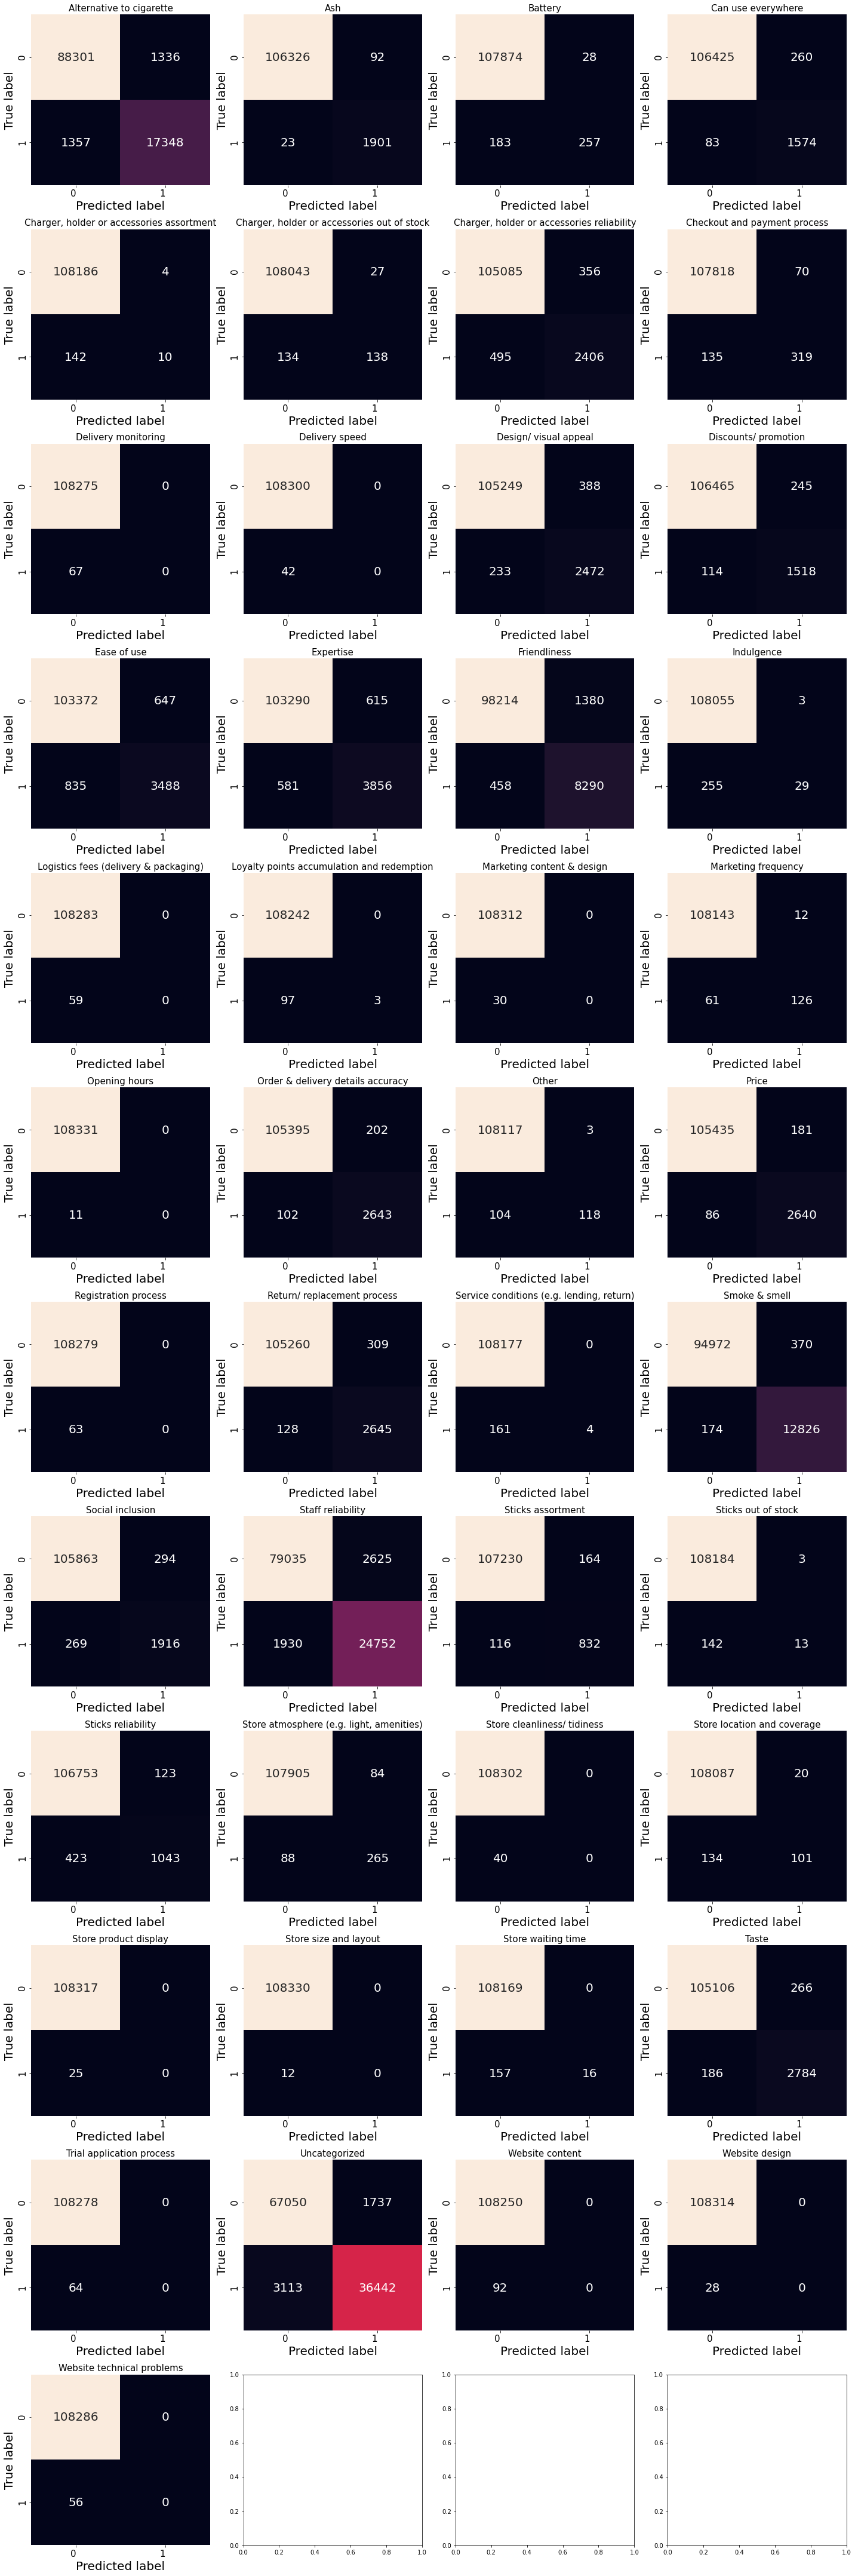

In [15]:
y_train, y_train_preds  = get_preds('train', verbose = True)
y_valid, y_valid_preds = get_preds('valid', verbose = True)
y_test, y_test_preds  = get_preds('test', verbose = True)

train_acc, train_acc_class, train_hamm, train_f1_score, train_f1_score_class, train_roc_auc, train_roc_auc_class = \
  calculate_metrics(y_train, y_train_preds, len(mlb.classes_), micro = True)

valid_acc, valid_acc_class, valid_hamm, valid_f1_score, valid_f1_score_class, valid_roc_auc, valid_roc_auc_class = \
  calculate_metrics(y_valid, y_valid_preds, len(mlb.classes_), micro = True)

test_acc, test_acc_class, test_hamm, test_f1_score, test_f1_score_class, test_roc_auc, test_roc_auc_class = \
  calculate_metrics(y_test, y_test_preds, len(mlb.classes_), micro = True)

print("Train:        Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (train_acc, train_f1_score, train_hamm, train_roc_auc))
print("Validation:   Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (valid_acc, valid_f1_score, valid_hamm, valid_roc_auc))
print("Test:         Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (test_acc, test_f1_score, test_hamm, test_roc_auc))

# print_classes_metrics(train_acc_class, train_f1_score_class, train_roc_auc_class, y_train, 
#                       valid_acc_class, valid_f1_score_class, valid_roc_auc_class, y_valid,
#                       test_acc_class, test_f1_score_class, test_roc_auc_class, y_test,
#                       mlb.classes_)
plot_cm(np.concatenate([y_train, y_valid, y_test]), 
        np.concatenate([y_train_preds, y_valid_preds, y_test_preds]), 
        mlb.classes_)

### Results with optimal probability threshold

Calculating optimal threshold



Train:        Accuracy: 0.00000, F1 score: 0.93434, Hamming Loss: 0.00387, ROC-AUC: 0.99592
Validation:   Accuracy: 0.70106, F1 score: 0.82046, Hamming Loss: 0.01056, ROC-AUC: 0.97029
Test:         Accuracy: 0.69036, F1 score: 0.81411, Hamming Loss: 0.01095, ROC-AUC: 0.96752


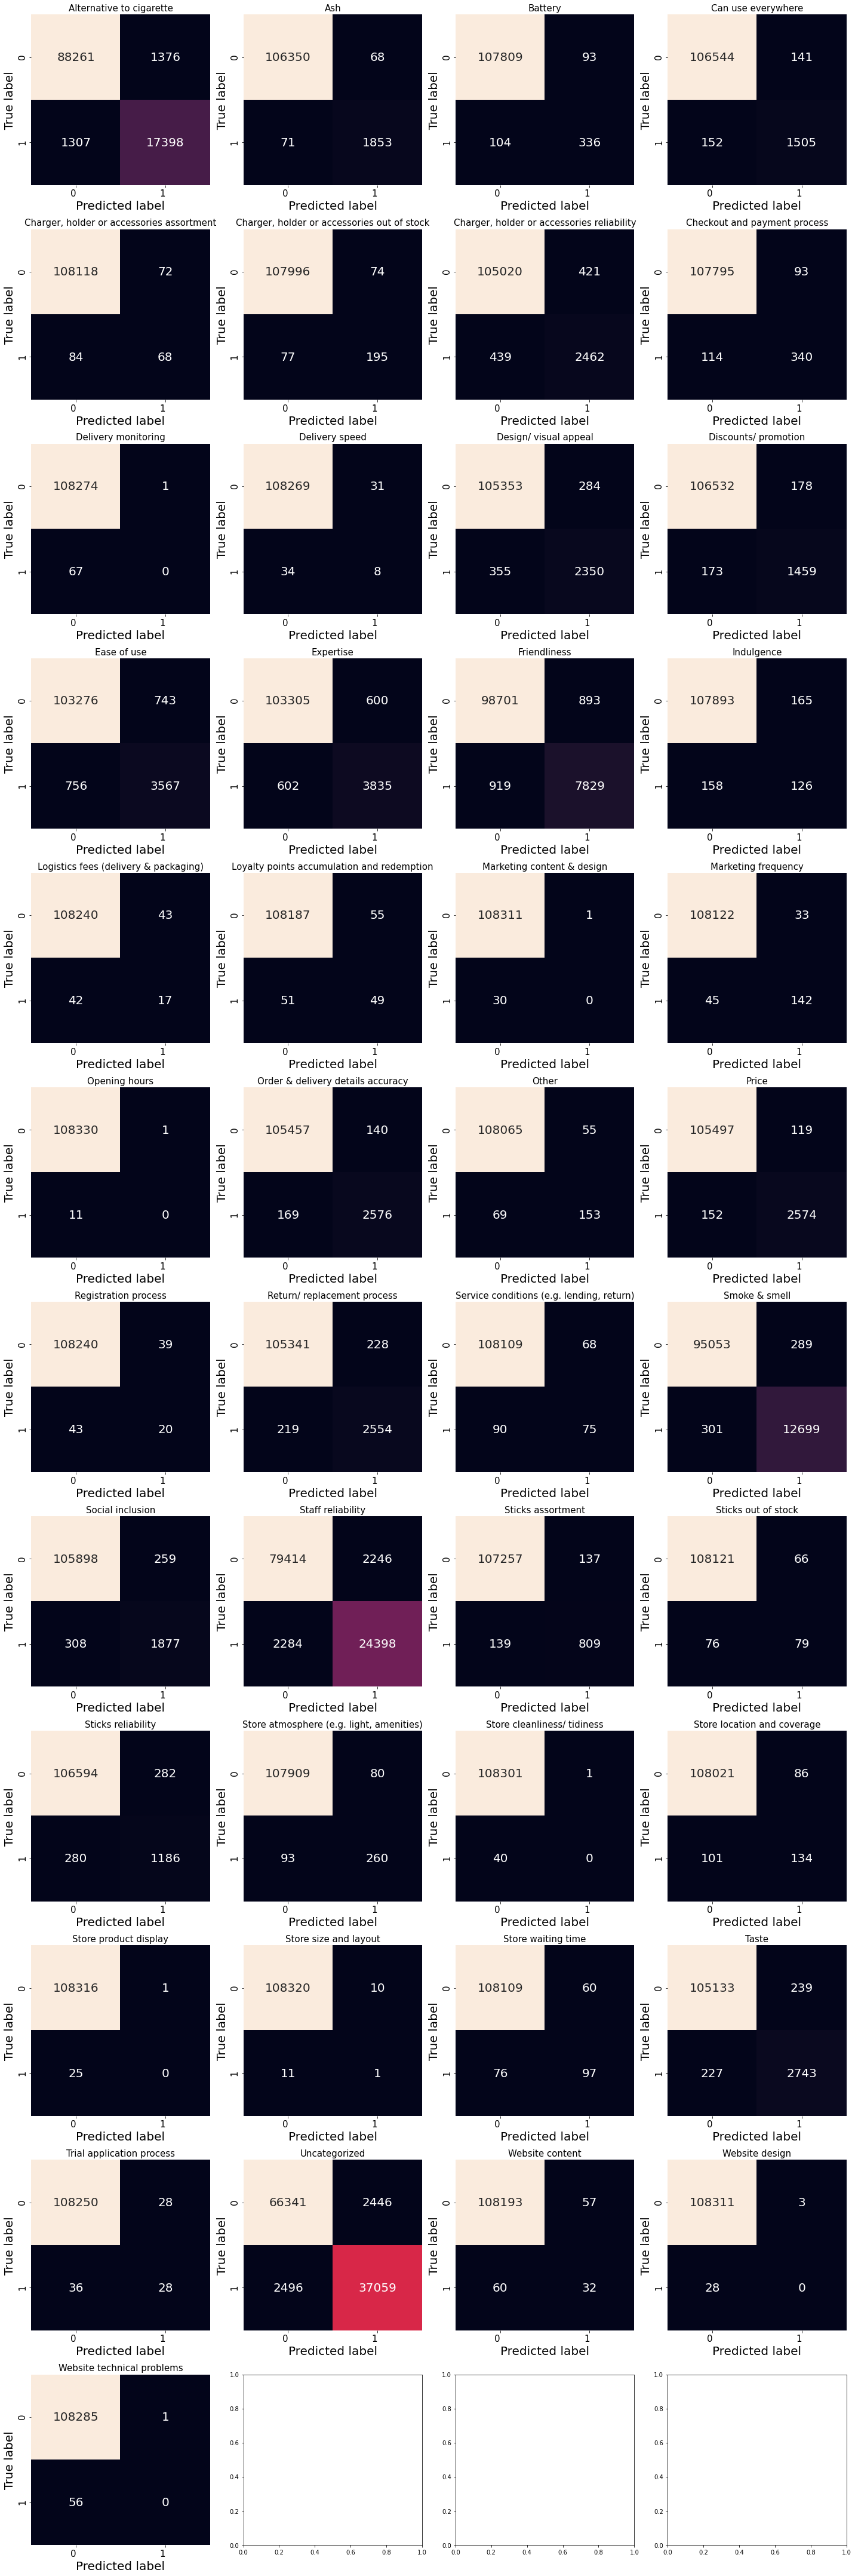

In [16]:
ts = optimal_threshold(y_train, y_train_preds, len(mlb.classes_), verbose = True)

train_acc_ts, train_acc_class_ts, train_hamm_ts, train_f1_score_ts, train_f1_score_class_ts, train_roc_auc_ts, train_roc_auc_class_ts = \
  calculate_metrics(y_train, y_train_preds, len(mlb.classes_), micro = True, ts = ts)

valid_acc_ts, valid_acc_class_ts, valid_hamm_ts, valid_f1_score_ts, valid_f1_score_class_ts, valid_roc_auc_ts, valid_roc_auc_class_ts = \
  calculate_metrics(y_valid, y_valid_preds, len(mlb.classes_), micro = True, ts = ts)

test_acc_ts, test_acc_class_ts, test_hamm_ts, test_f1_score_ts, test_f1_score_class_ts, test_roc_auc_ts, test_roc_auc_class_ts = \
  calculate_metrics(y_test, y_test_preds, len(mlb.classes_), micro = True, ts = ts)

print("Train:        Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (train_acc_ts, train_f1_score_ts, train_hamm_ts, train_roc_auc_ts))
print("Validation:   Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (valid_acc_ts, valid_f1_score_ts, valid_hamm_ts, valid_roc_auc_ts))
print("Test:         Accuracy: %.5f, F1 score: %.5f, Hamming Loss: %.5f, ROC-AUC: %.5f" % \
      (test_acc_ts, test_f1_score_ts, test_hamm_ts, test_roc_auc_ts))

# print_classes_metrics(train_acc_class_ts, train_f1_score_class_ts, train_roc_auc_class_ts, y_train, 
#                       valid_acc_class_ts, valid_f1_score_class_ts, valid_roc_auc_class_ts, y_valid,
#                       test_acc_class_ts, test_f1_score_class_ts, test_roc_auc_class_ts, y_test,
#                       mlb.classes_)
plot_cm(np.concatenate([y_train, y_valid, y_test]), 
        np.concatenate([y_train_preds, y_valid_preds, y_test_preds]), 
        mlb.classes_, ts = ts)

Save thresholds array

In [17]:
np.save(PATH_SAVE + r'/ts.npy', ts)

In [68]:
!cp {PATH_RUBERT + '/vocab.txt'} {PATH_SAVE + '/vocab.txt'}